# Position Reconstruction
(author: B.Paetsch, updated: 23.06.2020)

New: position function, exception handling in Waveform function, gain scaling factor in Waveform function

Idea position reconstruction: The z-position is calculated with the product of the drift velocity (1.44 mm/microsec) and the time difference between the prompt S1 and delayed S2 signal (drift time). We only look at events that first of all have a valid pulse found by the Peaks-function (Joey). Then we create a s1s2-list with all pulses divided into S1 and S2 pulses (this happens in the ....notebook of Zhuoran). Only events where we have both a S1 and a S2 peak are added to our s1s2-list. The position-function then calls the Waveform-reader (Joey), which creates a list of the channels that contributed most to the signals in one event and additionally determines the channel with the largest contribution (minchannel: lowest adc value). Thereby we scale each adc value with the according relative gain of this PMT. For the x- and y-position, the position of the PMT in minchannel (largest peak) is taken (only top PMTs).

Exception handling: For those events which have a waveform size larger than 350000 ns (large scintillation signal ), an exception handling is added to the Waveform-function, which skipps these kind of events and counts them. One example of those events is event number 23 in NG. In notebook 'ample_size.ipynb' can be found more information on these kind of events.

In [141]:
import Zip
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time, sys, pickle, math
from IPython.display import clear_output

# Channels in the detector
det_ch = { 'tpc': list(range(0, 247+1)), 'veto': list(range(248, 253+1)), 
          'sum_wv': [254], 'busy_on': [255], 'busy_off': [256],
          'hev_on': [257], 'hev_off': [258], 'muon_veto_trigger': [259], } 
n_channels = 260

# for reading the ini file
from configparser import ConfigParser, ExtendedInterpolation
config = ConfigParser(inline_comment_prefixes='#', interpolation=ExtendedInterpolation(), strict=True)
config.optionsxform = str
config.read('xenon1t.ini')

# Initial parameters
baseline_ = 16384. * np.ones(n_channels)
std_ = 2.3 * np.ones(n_channels)

# The data files
NG = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/NG") # Neutron data
Rn220 = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/Rn220") # Rn-220 data

In [144]:
#progress bar for running code
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [145]:
"""take gains into account for each adc value"""
"""only look at top PMTs (for position reconstruction)"""

# A waveform reader function
def Waveform(raw,eventnr):
    event = raw.get_single_event(eventnr)
    ch_top = eval(config['DEFAULT']['channels_top'])
    gain = eval(config['DEFAULT']['gains'])
                                
    #The variables that check if a channel is the minimum channel
    adcmin = 16382
    minchannel = 0
    
    #A list that holds all the channels with significant pulses 
    channellist = []
    
    #Create the datapoint arrays
    n = 350000  
    ts = np.ones((n_channels, n), dtype=np.int16)
    ts = ts * 16382 
    t = np.linspace(0, n, n) 
    counter = False
    
    #Loop over all pulses in the event
    for p in event.pulses:
        ch = p.channel
        if ch in ch_top:  #only top PMTs
            i = np.zeros(n_channels, dtype = int)
            for adc in p.raw_data:
                try:
                #Add the ADC value to the appropriate channel array
                    ts[ch][p.left + i[ch]] = adc
                    #print("adc: ", adc)
                    if gain[ch]!=0:
                        adc_corrected = 16382 - (16382 - adc)/gain[ch]*4911399 #corrected by relative gain
                        #print("%: ", gain[ch]/4800000)
                    else:
                        adc_corrected = np.inf #if we put 0 here, PMTs with 0 gain are taken into account for minchannel
                    #print("corrected: ",adc_corrected)
                    i[ch] = i[ch] + 1
                except IndexError:
                        counter = True
                        
                #Append all significant main channels to the list
                if adc_corrected < 15000 and ch not in channellist and ch in det_ch['tpc']:
                    channellist.append(ch)
                
                #Check which channel is the minimum channel
                if adc_corrected < adcmin:
                    adcmin = adc_corrected
                    minchannel = ch
                
    #Sort for convenience
    channellist.sort()
    return t, ts, channellist, minchannel, counter

In [126]:
#from Joey Staa
def Peaks (pulse, printall):
    
    q = 0
    left_t, right_t = 0, 0
    baseline = 16382.
    std = 2.3
    ch = pulse.channel
    wave = pulse.raw_data
    
    # The index for the minimum
    minindex = len(wave)
    
    # Variables for the average, the ratio and the slope
    avfound = 0
    samplelist = [wave[0]]
    ratio = 1
    slope = 0
    sw = 0

    s = np.std(wave)
    delta = baseline - np.min(wave)
    if min(s, delta) > 5*std:
        for samples in enumerate(wave):
            base_sub = samples[1] - baseline
            if abs(base_sub) > 5*std:
                q = q + base_sub
            
            # Compute the average of the previous samples
            av = np.average(samplelist)
            
            # left_t is assigned when a significant deviation from the average is recorded
            if abs(samples[1] - av) > 20 and left_t == 0:
                left_t = samples[0]
                
                # The sample value at left_t is kept for the slope calculation
                leftsample = samplelist[-1]
                if printall:
                    print("left_t here")
                avfound = av
             
            # Find the index for the minimum
            if samples[1] == np.min(wave):
                minindex = samples[0]

            # right_t is assigned in a similar way as left_t
            if abs(samples[1] - avfound) < 20 and samples[0] > minindex and right_t == 0: 
                right_t = samples[0]
                if printall:
                    print("right_t here")
                
            # Add the current sample to the sample list
            samplelist.append(samples[1])
            
            # A printing section in case the raw data needs to be analysed
            if printall:
                print(samples)
                print("Average:", av)
                if left_t == 0:
                    print("Average difference:", abs(samples[1] - av))
                else:
                    print("Average difference:", abs(samples[1] - avfound))
                print()
        
        # Calculate the ratio and the slope
        ratio = np.min(wave)/int(avfound)
        slope = (np.min(wave) - leftsample)/(minindex - left_t)
    else:
        baseline = np.average(wave)
        std = s
    width = right_t - left_t
    if width != 0:
        sw = slope/width
        if -q/width < 3*std or ratio >= 0.99:
            q = 0
    return (ch, q, width, pulse.left+left_t, sw)

In [146]:
#getting the already classified S1 and S2 signals stored in a list (Zhuoran Feng)
#NG_data.p: 10000 events
with open ('NG_data.p','rb') as fp:
    data = pickle.load(fp)

In [147]:
#checking whether it works
print(data[0])
print(len(data))
print(data[0]['event'])

{'event': 0, 's1': 110469.0, 's2': 1311152.0, 's1_position': 100055, 's2_position': 171748}
7490
0


In [165]:
#you need the Waveform reader, Peaks-function and the classified S1 and S2 signal list for running position-fct.
def position(raw,data):
    """ Finding the x,y and z position for an event, and storing the coordinates in a list.
    Only channel 254 is used."""
    
    position_list = []
    c = 0
    z = 0
    drift_velocity = 1.44 # mm/us, see Jelle p.78 or 1708.07051
    length_data = len(data)
    
    for event in data:
    #z-coordinate
        drift = 2e-3*(event['s2_position']-event['s1_position'])
        z = drift * drift_velocity #[mm]
    
    #x-,y-coordinate (we take the position of the minchannel PMT)
        (t, ts, channellist, minchannel, counter) = Waveform(raw,event['event'])
        if counter == True:
            c += 1
        pmt = eval(config['DEFAULT']['pmts'])
        x = pmt[minchannel]['position']['x']
        y = pmt[minchannel]['position']['y']
        
        entry = { 'eventnumber': event['event'], 'x': x, 'y': y, 
                     'z': z }
        position_list.append(entry)
        length = len(position_list)
        
        if (length/length_data)%0.1==0: #every 10% update the progress bar
            #print(length)
            update_progress(length/length_data) 
        if length==length_data: #delete this
            break
            
    return position_list, c #c: counter, how many events we skipped in Waveform-fct. due to a size>350000 

In [166]:
#create the position_list
start_time = time.time()

position_list, counter = position(raw,data)

print("position_list execution runtime: ", time.time()-start_time) #seconds

Progress: [################----] 80.0%
position_list execution runtime:  74980.34948897362


In [167]:
print(counter)
"""NG: event 23 has a length of 350000 + 185342 = 535342 
For more information on the waveforms that are broader than 350000 and are skipped in the x-y-position 
determination, have a look at the 'ample_size.ipynb' notebook. """

print(len(position_list))
print(position_list[0])

740
7490
{'eventnumber': 0, 'x': 15.90000000000001, 'y': 27.53960784034514, 'z': 206.47583999999998}


In [168]:
print(position_list[0]['x'])

15.90000000000001


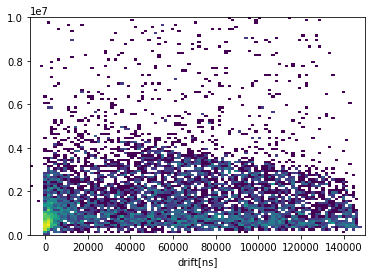

In [200]:
#plotting the drift time
s1 = []
s2 = []
drift = []
for event in data:
    drift.append(2*(event['s2_position']-event['s1_position']))
    s1.append(event['s1'])
    s2.append(event['s2'])
fig, ax = plt.subplots()
ax.hist2d(drift,s2, bins=(100,100), range=((-7000,150000), (0,1e7)), norm=mpl.colors.LogNorm())
ax.set_xlabel("drift[ns]")
fname = 'NG_drift10000.png'
fig.savefig(fname, dpi = (200))

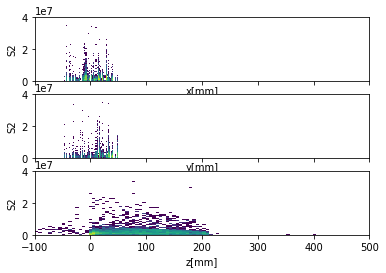

In [199]:
fig, ax = plt.subplots(3, 1, sharex='col')
ax[0].hist2d(x,s2, bins=(100,100), range=((-100, 100),(0, 40000000)), norm=mpl.colors.LogNorm())
ax[1].hist2d(y,s2, bins=(100,100), range=((-100, 100),(0, 40000000)), norm=mpl.colors.LogNorm())
ax[2].hist2d(z,s2, bins=(100,100), range=((-100, 500),(0, 40000000)), norm=mpl.colors.LogNorm())
ax[0].set_xlabel("x[mm]")
ax[1].set_xlabel("y[mm]")
ax[2].set_xlabel("z[mm]")
ax[0].set_ylabel("S2")
ax[1].set_ylabel("S2")
ax[2].set_ylabel("S2")
fname = 'NG_Position_zoom10000.png'
fig.savefig(fname, dpi = (200))

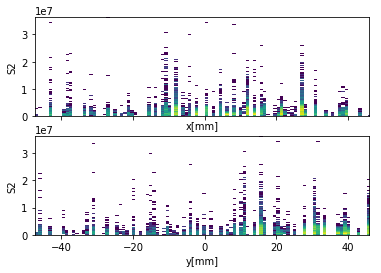

In [196]:
#plotting the x-, y- and z-coordinate
x = []
y = []
z = []
for position in position_list:
    #print(position)
    x.append(position['x'])
    y.append(position['y'])
    z.append(position['z'])
        
fig, ax = plt.subplots(2, 1, sharex='col')
ax[0].hist2d(x,s2, bins=(100,100), norm=mpl.colors.LogNorm())
ax[1].hist2d(y,s2, bins=(100,100), norm=mpl.colors.LogNorm())
ax[0].set_xlabel("x[mm]")
ax[1].set_xlabel("y[mm]")
ax[0].set_ylabel("S2")
ax[1].set_ylabel("S2")
fname = 'x-y-position10000.png'
fig.savefig(fname, dpi = (200))

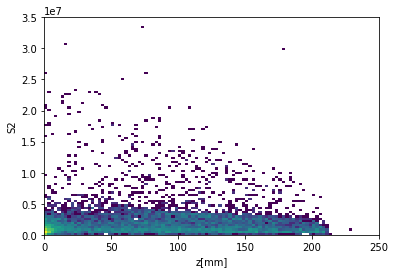

In [204]:
fig, ax = plt.subplots()
ax.hist2d(z,s2, bins=(100,100), range=((0,250),(0,3.5*1e7)), norm=mpl.colors.LogNorm())
ax.set_xlabel("z[mm]")
ax.set_ylabel("S2")
fname = 'NG_z-position10000.png'
fig.savefig(fname, dpi = (200))

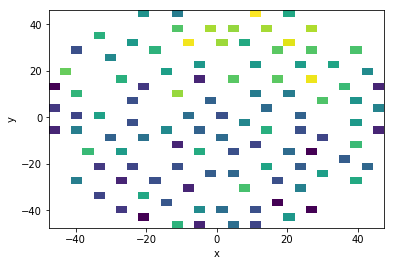

In [201]:
fig, ax = plt.subplots()
ax.hist2d(x,y, bins=(30,30), norm=mpl.colors.LogNorm())
ax.set_xlabel("x")
ax.set_ylabel("y")
fname = 'NG_x-y-position10000.png'
fig.savefig(fname, dpi = (200))